In [1]:
import numpy
import numpy as np
import pandas
import pandas as pd
from numba import njit
import sys,glob
import zipfile, os, time
import urllib3
from datetime import datetime, timedelta
import glob
import h5py
sys.path.append(os.getcwd()+'/../../cds-backend/code/')
sys.path.append(os.getcwd()+'/../../harvest/code/')
#sys.path=[os.getcwd()+'/../../resort/rasotools-master/']+sys.path
sys.path.insert(0,os.getcwd()+'/../../resort/rasotools-master/')
#print(sys.path)
# sys.path.append(os.getcwd()+'/../../resort/rasotools-master/')
import rasotools
#print(dir(rasotools))
from harvest_convert_to_netCDF_newfixes import write_dict_h5
import cds_eua3 as eua
eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time
#import schedule
import copy
from shutil import copyfile
import multiprocessing
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings('ignore')



In [2]:
@njit        
def tcost(dists, slopes, cost):
    # calculate trend heterogeneity cost function

    id = 0
    goodstats = 0
    tcost = 0.
    for l in range(slopes.shape[0]):
        cost[l] = 0.
    for l in range(slopes.shape[0]):
        if slopes[l] == slopes[l]:
            goodstats += 1
            for k in range(l, slopes.shape[0]):
                if slopes[l] == slopes[l] and slopes[k] == slopes[k]:
                    s = (slopes[l]-slopes[k])*dists[id]
                    cost[l] += s*s
                    cost[k] += s*s
                    if l == 24 and k == 29:
                        print((dists[id], slopes[l], slopes[k]))
                id += 1
            if goodstats > 0:
                tcost += cost[l]
        else:
            id += slopes.shape[0]-l

    if goodstats > 0:
        tcost /= goodstats
        for l in range(slopes.shape[0]):
            cost[l] /= goodstats

    return tcost

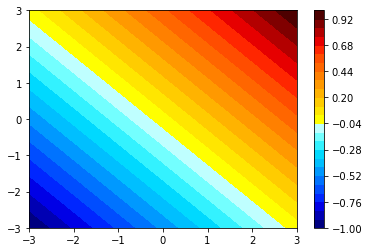

ready


In [3]:
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
"rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
"rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
"rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
"rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
"rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
"rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
"rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
"rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

cmnew=make_colormap(rgblist2)

x,y=numpy.meshgrid(numpy.linspace(-3,3,101),numpy.linspace(-3,3,101))
gauss=x/6+y/6
clist=numpy.linspace(-1,1,26)
plt.contourf(x,y,gauss,clist,cmap=cmnew)
plt.colorbar()
plt.show()
print('ready')

## plotting function

In [4]:
def plt_trends(ll,pdict,var='_',bias='_'):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)

#     igra = pickle.load( open( i, "rb" ))
#     i = i.split('/')[-1]
#     da = igra.dropna()
#     print(da)
#     statnum = len(da)
    if 'scale' not in pdict.keys():
        pdict['scale']=2.0
    lla=np.asarray(ll)
    idx=np.where(~np.isnan(lla[:,0]))[0]
    lla=lla[idx,:]
    print(lla.shape)
    # column0=trend, column1=lat,column2=lon
    a = rasotools.plot._helpers.cost(lla[:,2],lla[:,1],lla[:,0])
    cost = np.sum(a)/len(a)
    
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

#     reduced = np.asarray(da['station_name'])
#     longitudes = list(da['location_longitude'])
#     latitudes = list(da['location_latitude'])
    plt.scatter(lla[:,2], lla[:,1], s=40, alpha=1,
                c= lla[:,0],
                cmap=cmnew,
                vmin=-pdict['scale'],
                vmax=pdict['scale'],
                edgecolor='k',)
    plt.colorbar(orientation='horizontal', label='Trend '+pdict['units'], shrink=0.9, pad=0.05)
    plt.tight_layout()
#     plt.title('CUAN'+i.split('.')[0][4:]+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(statnum))
#     plt.savefig('plots/'+'CUAN'+i[4:]+'ng', bbox_inches='tight')
#     names={'_':'unadjusted','bias_estimate':'ERA5 adjusted','RISE_bias_estimate':'RISE adjusted'}
    plt.title('CUON '+names[bias]+', '+str(pdict['start'])+'-'+str(pdict['stop'])+', '+str(pdict['pl'])+'hPa\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(lla.shape[0]))
        
    try:
        os.mkdir('plots_new')
    except:
        pass
    plt.savefig('plots_new/cuon_'+names[bias], bbox_inches='tight')
    plt.close()


# Trends

---

## Requesting CUAN Data

In [5]:
import numpy
import numpy as np
import pandas as pd
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
import warnings
import shutil
import pickle
import json
import requests, zipfile, io
warnings.filterwarnings('ignore')

def berequest(rqdict, source, remove_file=True):
    rqdict['pressure_level']*=100
#     rqdict['variable']='temperature'
    sdict="'"+json.dumps(rqdict)+"'"
    t0=time.time()
    print(os.getcwd())
    os.chdir(os.path.expandvars('$RSCRATCH/tmp'))
#     print(sdict)
#    data=eua.vm_request_wrapper(rqdict, overwrite=True,vm_url='http://srvx8.img.univie.ac.at:8002')#.values()
#    !curl -H "Content-Type: application/json" -X POST --digest --data $sdict -o /raid60/scratch/leo/scratch/tmp/download.zip http://srvx8.img.univie.ac.at:8002
    r = requests.post('http://srvx8.img.univie.ac.at:8002/',
                  headers={'content-type': 'application/json'},
                  json=rqdict,
                  stream=True)
#
# Check for known Error Message
#
    if r.status_code != requests.codes.ok:
         print(r.text)
         raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
    if not os.path.isdir('./example_data'):
        os.makedirs('./example_data')
#
# Unzip the Data Stream
#
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        print("Retrieved files: ")
#         print(z.namelist())
        z.extractall(path='./example_data')
        z.close()
        print("Time elapsed: ", time.time()-t0, "s")
        return os.getcwd()+'/example_data'
    except:
        print(r.text)
        print("Error in request")
        print("Time elapsed: ", time.time()-t0, "s")
        return 'Error '+r.text

def request(rqdict, source, remove_file=True):
    t0 = time.time()
    c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2',
                  key='1113:e8b7f777-d553-434f-9c31-ef2820b069d4',
                  progress=True,retry_max=5)

    r = c.retrieve(
        source,rqdict)
    if True:
        r.download(target='download.zip')
        assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./download/')
    z.close()
    print('Request took: ' + str(time.time() - t0) + ' seconds')
    
    files = glob.glob('./download/*.nc')
    
    if files[0].split('/')[-1].startswith('IGRA'):
        ds = xarray.open_dataset(files[0])            
        data = ds.to_dataframe()
        for i in files[1:]:
            ds = xarray.open_dataset(i)            
            data = data.append(ds.to_dataframe())

    else:
        data=eua.CDMDataset(files[0]).to_dataframe()
        for i in files[1:]:
            da = eua.CDMDataset(i).to_dataframe()
            data = data.append(da)
            
    os.remove('download.zip')
    if remove_file:
        try:
           shutil.rmtree('./download/')
        except:
           print('Error while deleting directory')

    return data

print(os.getcwd())
iodir='/raid60/scratch/leo/scratch/tmp'
http = urllib3.PoolManager()
r = http.request('GET', 'http://srvx8.img.univie.ac.at:8002/statlist/?mindate=1900-01-01&enddate=2020-12-31')
fns=r.data.split(b'\n')
for i in range(len(fns)):
    fns[i]=fns[i].split(b',')[0].decode()

del fns[0]
print(fns[0])
#stations = pickle.load( open( "stations.p", "rb" ))
#print(stations.station_name)
#for i in ['all']: #stations.station_name[:3]:
#    if not iodir+'/COMP_'+str(i)+'_100.p' in glob.glob(iodir+'/*'):
#del data
start=1979
stop=2019

# try:
#     data = berequest({'variable':['temperature'],
#                     'statid': fns,
#                     'period': str(start)+'-01-01/'+str(stop)+'-12-31',
#                     'optional':['bias_estimate','RISE_bias_estimate'],
#                     'pressure_level': 100
#                     }, 'insitu-comprehensive-upper-air-observation-network',
#       )
# except MemoryError as e:
#     print(i,e)
    
#pickle.dump( data, open( iodir+'/COMP_' + str(i) + '_100.p', "wb" ))
tfns=glob.glob(data+'/*air_temperature*.nc')
print(fns)

#     else:
#         print('-')


/fio/srvx7/leo/python/CEUAS/CEUAS/public/adjust/Notebooks
0-20000-0-16052


NameError: name 'data' is not defined

## Creating Trendfiles from CUAN

In [ ]:
@njit(cache=True)
def fastlinregress(x,y):
#    print typeof(x),typeof(y)
    m=x.shape[0]
    miss_val=np.nan
    
    xmean=0.
    ymean=0.
    xcov=0.
    xsq=0.
    n=0
    for k in range(m):
        if x[k]==x[k] and y[k]==y[k]:
            xmean+=x[k]
            ymean+=y[k]
            n+=1
    if n>2:   
        xmean/=n
        ymean/=n
        for k in range(m):
            if x[k]==x[k] and y[k]==y[k]:
                xcov+=x[k]*y[k]
                xsq+=x[k]*x[k]
        slope=(xcov-n*xmean*ymean)/(xsq-n*xmean*xmean)
    else:
        slope=miss_val

    return slope


In [24]:
from functools import partial
def calc_trend_from_nc(start,stop,bias,fak,fn):
    
    yearsec=np.int(365.25*86400)
    istart=(start-1900)*yearsec
    istop=(stop-1900)*yearsec
    var='_'.join(fn.split('/')[-1].split('.nc')[0].split('_')[-2:])
    vars={'air_temperature':'ta','northward_wind':'va','eastward_wind':'ua','relative_humidity':'hur'}
    with h5py.File(fn,'r') as f:
        times=f['time'][:]
        trange=[np.searchsorted(times,istart),np.searchsorted(times,istop)]
#        print(trange)
        lat=f['lat'][0]
        lon=f['lon'][0]
        
        if trange[0]==len(times):
            return (np.nan,lat,lon)
        if times[trange[0]]//yearsec+1900>start+2 or times[trange[1]-1]//yearsec+1900<stop-2:
#             print(times[trange[0]]//yearsec+1900,times[trange[1]-1]//yearsec+1900,start+2,stop-2)
            return (np.nan,lat,lon)
        times=times[trange[0]:trange[1]]
        if len(times)<(istop-istart)/2/86400:
#             print(len(times))
            return (np.nan,lat,lon)
        
#                 temp.ta = temp.ta - numpy.nan_to_num(temp.bias_estimate)
#         xa=xr.DataArray(data=f['ta'][trange[0]:trange[1]],name='ta',dims={'time':len(times)},
#                             coords={'time':times})#,'lat':np.asarray([f['lat'][0]]),'lon':np.asarray([f['lon'][0]])})
#                 xa = temp.set_index(['lat', 'lon', 'time']).to_xarray()
#         print(xa)
        out = fastlinregress(times/yearsec/10,f[vars[var]][trange[0]:trange[1]]*fak)
        if bias !='_':
#             print(bias,type(f['ta'][trange[0]:trange[1]]),type(f[bias][trange[0]:trange[1]]))
            try:
                ts=f[vars[var]][trange[0]:trange[1]][:]-f[bias][trange[0]:trange[1]][:]
                out = fastlinregress(times/yearsec/10,ts*fak)
            except:
                out=np.nan
            
#          out = rasotools.met.time.trend(xa,only_slopes=True) #.to_dataframe(name='out')
#        out=float(out.iloc[-1] *3650)
        
#    print(fn.split('/')[-1].split('_air_')[0][-5:],out)
    return (out,lat,lon)

pdict=dict(var='temperature',pl=300,start=1979,stop=2019,units=r'K/10a')
names={'_':'unadjusted','bias_estimate':'ERA5 adjusted','RISE_bias_estimate':'RISE adjusted'}
for k,v in names.items():
    func=partial(calc_trend_from_nc,start,stop,k,1.0)
    ll=list(map(func,tfns))
#     print(ll)
    plt_trends(ll,pdict,bias=k)


(627, 3)
(627, 3)
(625, 3)


## Wind

In [225]:
from multiprocessing import Pool
r = http.request('GET', 'http://srvx8.img.univie.ac.at:8002/statlist/?mindate=1900-01-01&enddate=2020-12-31')
fns=r.data.split(b'\n')
for i in range(len(fns)):
    fns[i]=fns[i].split(b',')[0].decode()

del fns[0]
# fns=[fns[fns.index('0-20000-0-35229')]]
# print(fns)

pdict=dict(var='v_component_of_wind',pl=300,start=1979,stop=2019,units=r'ms$^{-1}$/10a')
# try:
#     data = berequest({'variable':'v_component_of_wind',
#                     'statid': fns,
#                     'period': str(start)+'-01-01/'+str(stop)+'-12-31',
#                     'optional':['wind_bias_estimate'],
#                     'pressure_level': pl
#                     }, 'insitu-comprehensive-upper-air-observation-network',
#       )
# except Exception as e:
#     print(i,e)
    
#pickle.dump( data, open( iodir+'/COMP_' + str(i) + '_100.p', "wb" ))
wfns=glob.glob(data+'/*northward_wind*.nc')

names={'_':'wind_unadjusted','wind_bias_estimate':'wind_adjusted'}#,
#        'u_component_of_wind_bias_estimate':'wind adjusted','RISE_bias_estimate':'RISE adjusted',
#        'RASE_bias_estimate':'RASE adjusted','RICH_bias_estimate':'RICH adjusted',
#        'RAOBCORE_bias_estimate':'RAOBCORE adjusted'}
P=Pool(20)
for k,v in names.items():
    func=partial(calc_trend_from_nc,start,stop,1.0,k)
    ll=list(P.map(func,wfns))
#     print(ll)
    print(k)
    plt_trends(ll,pdict,bias=k)


_
(649, 3)
wind_bias_estimate
(649, 3)


## Relative Humidity

In [237]:
from multiprocessing import Pool
r = http.request('GET', 'http://srvx8.img.univie.ac.at:8002/statlist/?mindate=1900-01-01&enddate=2020-12-31')
fns=r.data.split(b'\n')
for i in range(len(fns)):
    fns[i]=fns[i].split(b',')[0].decode()

del fns[0]
# fns=[fns[fns.index('0-20000-0-35229')]]
# print(fns)

pdict=dict(var='relative_humidity',pl=300,start=1979,stop=2019,units=r'\%/10a',scale=10.)
try:
    data = berequest({'variable':'relative_humidity',
                    'statid': fns,
                    'period': str(pdict['start'])+'-01-01/'+str(pdict['stop'])+'-12-31',
                    'optional':['humidity_bias_estimate'],
                    'pressure_level': pdict['pl']
                    }, 'insitu-comprehensive-upper-air-observation-network',
      )
except Exception as e:
    print(i,e)
    
wfns=glob.glob(data+'/*relative_humidity*.nc')

names={'_':'RH_unadjusted','humidity_bias_estimate':'RH_adjusted'}#,
#        'u_component_of_wind_bias_estimate':'wind adjusted','RISE_bias_estimate':'RISE adjusted',
#        'RASE_bias_estimate':'RASE adjusted','RICH_bias_estimate':'RICH adjusted',
#        'RAOBCORE_bias_estimate':'RAOBCORE adjusted'}
P=Pool(20)
for k,v in names.items():
    func=partial(calc_trend_from_nc,start,stop,k,100.0)
    ll=list(P.map(func,wfns))
#     print(ll)
    print(k)
    plt_trends(ll,pdict,bias=k)


/raid60/scratch/leo/scratch/tmp
Retrieved files: 
Time elapsed:  546.6505076885223 s
_
(563, 3)
humidity_bias_estimate
(559, 3)


## Desrozier estimate

In [6]:
print(os.getcwd())
iodir='/raid60/scratch/leo/scratch/tmp'
http = urllib3.PoolManager()
r = http.request('GET', 'http://srvx8.img.univie.ac.at:8002/statlist/?mindate=1979-01-01&enddate=1979-12-31')
fns=r.data.split(b'\n')
for i in range(len(fns)):
    fns[i]=fns[i].split(b',')[0].decode()

del fns[0]
print(fns[0])
#stations = pickle.load( open( "stations.p", "rb" ))
#print(stations.station_name)
#for i in ['all']: #stations.station_name[:3]:
#    if not iodir+'/COMP_'+str(i)+'_100.p' in glob.glob(iodir+'/*'):
#del data
start=1979
stop=1979

try:
    data = berequest({'variable':['temperature'],
                    'statid': fns,
                    'period': str(start)+'-01-01/'+str(stop)+'-12-31',
                    'optional':['desroziers_180'],
                    'pressure_level': 100
                    }, 'insitu-comprehensive-upper-air-observation-network',
      )
except MemoryError as e:
    print(i,e)
    
#pickle.dump( data, open( iodir+'/COMP_' + str(i) + '_100.p', "wb" ))
tfns=glob.glob(data+'/*air_temperature*.nc')
print(len(tfns))

#     else:
#         print('-')


/fio/srvx7/leo/python/CEUAS/CEUAS/public/adjust/Notebooks
0-20000-0-16052
/fio/srvx7/leo/python/CEUAS/CEUAS/public/adjust/Notebooks
Retrieved files: 
Time elapsed:  264.5004620552063 s
2928


In [13]:
def plt_unc(ll,pdict,var='_',bias='_'):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)

#     igra = pickle.load( open( i, "rb" ))
#     i = i.split('/')[-1]
#     da = igra.dropna()
#     print(da)
#     statnum = len(da)
    if 'scale' not in pdict.keys():
        pdict['scale']=2.0
    lla=np.asarray(ll)
    idx=np.where(~np.isnan(lla[:,0]))[0]
    lla=lla[idx,:]
    print(lla.shape)
    # column0=trend, column1=lat,column2=lon
    a = rasotools.plot._helpers.cost(lla[:,2],lla[:,1],lla[:,0])
    cost = np.sum(a)/len(a)
    
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

#     reduced = np.asarray(da['station_name'])
#     longitudes = list(da['location_longitude'])
#     latitudes = list(da['location_latitude'])
    plt.scatter(lla[:,2], lla[:,1], s=40, alpha=1,
                c= lla[:,0],
                cmap=cmnew,
                vmin=0.,
                vmax=pdict['scale'],
                edgecolor='k',)
    plt.colorbar(orientation='horizontal', label='Mean uncertainty '+pdict['units'], shrink=0.9, pad=0.05)
    plt.tight_layout()
#     plt.title('CUAN'+i.split('.')[0][4:]+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(statnum))
#     plt.savefig('plots/'+'CUAN'+i[4:]+'ng', bbox_inches='tight')
#     names={'_':'unadjusted','bias_estimate':'ERA5 adjusted','RISE_bias_estimate':'RISE adjusted'}
    plt.title('CUON '+pdict['unc']+', '+str(pdict['start'])+'-'+str(pdict['stop'])+', '+str(pdict['pl'])+'hPa\n'+'heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(lla.shape[0]))
        
    try:
        os.mkdir('plots_new')
    except:
        pass
    plt.savefig('plots_new/cuon_uncertainty_'+names[bias]+'_'+str(pdict['start'])+'-'+str(pdict['stop']), bbox_inches='tight')
    plt.close()


In [15]:
from functools import partial
def calc_uncaverage(start,stop,bias,fak,fn):
    
    yearsec=np.int(365.25*86400)
    istart=(start-1900)*yearsec
    istop=(stop-1900)*yearsec
    var='_'.join(fn.split('/')[-1].split('.nc')[0].split('_')[-2:])
    vars={'air_temperature':'desroziers_180','northward_wind':'va','eastward_wind':'ua','relative_humidity':'hur'}
    with h5py.File(fn,'r') as f:
        times=f['time'][:]
        trange=[np.searchsorted(times,istart),np.searchsorted(times,istop)]
#        print(trange)
        lat=f['lat'][0]
        lon=f['lon'][0]
        
        try:
            x=f[vars[var]][trange[0]:trange[1]]
            mask=~np.isnan(x)
#            print(x.shape,sum(mask),len(mask))
            if sum(mask)>len(mask)/2:
                out = np.mean(x[mask]*fak)
            else:
                out=np.nan
        except:
            out=np.nan

    return (out,lat,lon)

pdict=dict(var='temperature',pl=300,start=2009,stop=2009,scale=2.0,units=r'K',unc='Desroziers_180')
names={'_':'unadjusted'} #,'bias_estimate':'ERA5 adjusted','RISE_bias_estimate':'RISE adjusted'}
for k,v in names.items():
    func=partial(calc_uncaverage,pdict['start'],pdict['stop']+1,k,1.0)
    ll=list(map(func,tfns))
#     print(ll)
    plt_unc(ll,pdict,bias=k)


(756, 3)
